## Imports

In [38]:
import numpy as np
import sys, getopt
from random import randint
from math import sqrt
import matplotlib.pyplot as plt
import matplotlib.cm as colorMap
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')
import os
import pandas as pd

## Importing Modules for PCA
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

## Functions

In [48]:
# Function to read the data from the file
def folder(pathname):
    path = os.getcwd()
    file = path + pathname
    df = pd.read_csv(file, delimiter="\t", header=None,index_col=False)
    return df

# To find out the initial centroids using the given indices
def initial_centroids(data,c):
    centroid_data = []
    for i in range(int(c)):
        centroid_data.append(data[i])
    return np.asarray(centroid_data)

# Method to classify data points to which centroid or which cluster.
def classify(data,centroids):
    euc_all = []
    for i in range(len(centroids)):
        euc_all.insert(i, distance(data, centroids[i]))
        #print(np.argmin(euc_all))
    
    return np.argmin(euc_all) + 1

# Method which returns the distance between a datapoint and the centroid.
def distance(data,centroid):
    distance = 0
    for i in range(len(data)):
        distance += ((data[i] - centroid[i]) ** 2)
    
    return sqrt(distance)

# Update the centroids
def update(data, clustered_class, old_centroids):
    centroids = []
    for i in range(len(old_centroids)):
        temp_array = np.asarray([np.where(clustered_class[:] == i+1)][0])[0]
        per_cluster = data[temp_array,:]
        if len(per_cluster) == 0:
            centroids.insert(i, old_centroids[i])
        else:
            centroids.insert(i,np.mean(per_cluster, axis=0))
    return np.asarray(centroids)

# Generate an Incidence Matrix to Calculate Coefficients
def incidence_matrix(classes):
    class_length = len(classes)
    incidence_mat = np.zeros((class_length, class_length))
    val = None
    for i in range(class_length):
        for j in range(class_length):
            if classes[i] == classes[j]:
                val = 1
            else:
                val = 0
            incidence_mat[i][j] = val
    return incidence_mat

# Method to Plot the graph
def plot_2D(centroids, pca_data, c_classes,fileName):
    legend = list()
    classes = np.unique(c_classes)
    class_len = len(classes)
    colors = colorMap.Set1(np.linspace(0, 1, class_len))
    for i in range(class_len):
        cluster_data = pca_data[np.where(c_classes[:] == classes[i])]
        legend.append(plt.scatter(cluster_data[:, 0], cluster_data[:, 1], c=colors[i], s=10))
        plt.scatter(centroids[i, 0], centroids[i, 1], s=100, marker="x", c=colors[i])
    plt.legend(legend, classes,title="Clusters",fancybox="True")
    plt.title("KMeans on " + str(fileName))
    plt.show()

# Method to Reduce the total number of Components.
def Reduced_Plot(components, new_centroids, real_data, k, cluster_class, inputfile):
    #print(real_data.shape)
    #print(new_centroids.shape)
    pca = PCA(n_components=components).fit_transform(np.vstack((new_centroids, real_data)))
    pca_c = pca[0:k, :]
    pca = pca[k:, :]
    #print(pca_c)
    #print(pca.shape)
    plot_2D(pca_c,pca,cluster_class,inputfile)

# Method to count the number of True Positive, TN, FP, FN.
def validate_count(ground_truth, data_matrix):
    m11 = m00 = m10 = m01 = 0.0
    for i in range(len(ground_truth)):
        for j in range(len(ground_truth)):
            if ground_truth[i][j] == data_matrix[i][j]:
                if ground_truth[i][j] == 1:
                    m11 = m11 + 1
                else:
                    m00 = m00 + 1
            
            else:
                if ground_truth[i][j] == 1:
                    m10 = m10 + 1
                else:
                    m01 = m01 + 1
    return m11, m00, m10, m01
    
# Methods which calculate the Coefficients.
def calc_jaquard(m11, m00, m10, m01):
    return (m11 / (m11 + m10 + m01))

def calc_rand(m11, m00, m10, m01):
    return ((m11+m00)/(m11+m00+m10+m01))

## Main Method

Enter File Name: GMM_tab_seperated.txt
Indices or No.of.centroids : 2
No.of.Iterations: 50
input File : GMM_tab_seperated.txt, centroids : 2 , iterations : 50
Convereged after : 9 iterations.
Any Specific Requirements for the no.of.components: y or n: n
Jaccard Coefficient: 0.6385231048021746
Rand Index: 0.808504


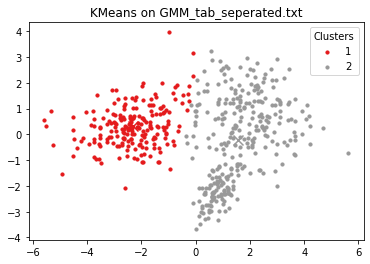

In [49]:
    
# Main Method
def main(*argv):
    inputfile = argv[0]
    centroids = argv[1]
    iterations = argv[2]
    len_of_centroid = None
    
    if centroids is None:
        centroids = 3  ## Default
    if iterations is None:
        iterations = 30 ## Default
    print(f"input File : {inputfile}, centroids : {centroids} , iterations : {iterations}")

    # Passing Folder
    df = folder(str('/' + inputfile))
    numpy_df = df.to_numpy()

    # Processing Dataset
    gene_id = numpy_df[:, 0] # First Column
    ground_truth = numpy_df[:, 1].astype(int)  # Classes , Second Column
    unq_classes = np.unique(ground_truth)
    class_length = len(unq_classes)
    ground_truth_matrix = incidence_matrix(ground_truth)
    real_data = np.delete(numpy_df, [0, 1], axis=1)
    
    # Getting Centroids from indices
    if isinstance(centroids,str) and len(centroids) >1:
        centroid_data = real_data[np.asarray(centroids.split(',')).astype(int) - 1, :].astype(float)
        
    # Picking Centroids randomly from the data
    else: 
        centroid_data = initial_centroids(real_data, centroids)
        

    k = len(centroid_data)
    count = 1
    for i in range(int(iterations)):
        cluster_class = []
        for j in range(len(real_data)):
            cluster_class.insert(j, classify(real_data
            [j], centroid_data))
        
        cluster_class = np.asarray(cluster_class)
        new_centroids = update(real_data, cluster_class, centroid_data)
        #print(new_centroids)

        if np.array_equal(centroid_data, new_centroids):
            break
        centroid_data = new_centroids
        count = count + 1
    print("Convereged after : " + str(count) + " iterations.")

    # Dimensionality Reduction
    components = None
    option = str(input("Any Specific Requirements for the no.of.components: y or n: "))
    if option == 'y':
        components = int(input("Enter the no.of.components: "))
        components = components
    else:
        components = 2

    final_matrix = incidence_matrix(cluster_class.astype(int))
    m11, m00, m10, m01 = validate_count(ground_truth_matrix, final_matrix)

    print("Jaccard Coefficient: " + str(calc_jaquard(m11, m00, m10, m01)))

    print("Rand Index: " + str(calc_rand(m11, m00, m10, m01)))
    
    Reduced_Plot(components, new_centroids, real_data, k, cluster_class, inputfile)


if __name__ == "__main__":
    file = input("Enter File Name: ")
    centroids = input("Indices or No.of.centroids : ")
    iterations = input("No.of.Iterations: ")
    main(file,centroids,iterations)